In [7]:
!pip install contractions

In [6]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

In [8]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv('/content/drive/MyDrive/AIML/Sarcastic or Not Sarcastic/sarcastic_headlines.csv')
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


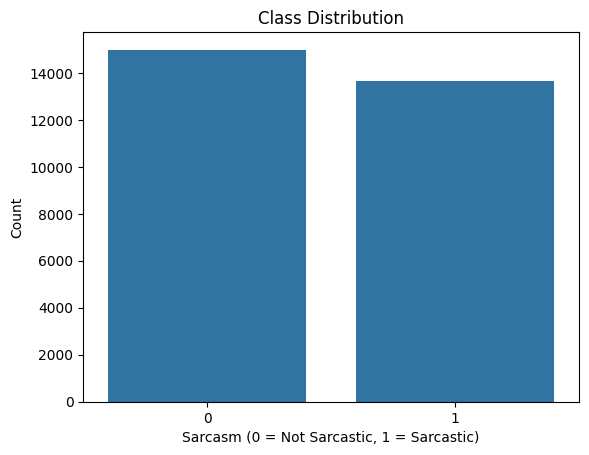

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64


In [10]:
# Check the distribution of the classes
sns.countplot(x='is_sarcastic', data=df)
# Display the distribution
plt.title('Class Distribution')
plt.xlabel('Sarcasm (0 = Not Sarcastic, 1 = Sarcastic)')
plt.ylabel('Count')
plt.show()
# Print numbers also
print(df['is_sarcastic'].value_counts())

In [11]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB
None

Missing Values:
headline        0
is_sarcastic    0
dtype: int64

First 5 rows:
                                            headline  is_sarcastic
0  thirtysomething scientists unveil doomsday clo...             1
1  dem rep. totally nails why congress is falling...             0
2  eat your veggies: 9 deliciously different recipes             0
3  inclement weather prevents liar from getting t...             1
4  mother comes pretty close to using word 'strea...             1


In [12]:
# Define all small cleaning steps first
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_unwanted_characters(text):
    text = re.sub(r'@\w+', '', text)  # Mentions
    text = re.sub(r'#\w+', '', text)  # Hashtags
    text = re.sub(r'\d+', '', text)   # Numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Special characters
    text = re.sub(r'\s+', ' ', text)  # Extra spaces
    return text.strip()

def remove_duplicate_words(text):
    words = text.split()
    new_words = []
    prev_word = None
    for word in words:
        if word != prev_word:
            new_words.append(word)
            prev_word = word
    return ' '.join(new_words)

# Now the main pipeline function
def text_cleaning_pipeline(text, rule="lemmatize"):
    # Expand contractions
    text = contractions.fix(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = remove_urls(text)

    # Remove emojis
    text = remove_emojis(text)

    # Remove unwanted characters
    text = remove_unwanted_characters(text)

    # Remove duplicate words
    text = remove_duplicate_words(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Apply lemmatization
    if rule == "lemmatize":
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)


In [13]:
# Apply text cleaning to the dataset
df['cleaned_headline'] = df['headline'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

# Show cleaned examples
df[['headline', 'cleaned_headline']].head()

,headline,cleaned_headline
0,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist unveil doomsday cloc...
1,dem rep. totally nails why congress is falling...,dem rep totally nail congress falling short ge...
2,eat your veggies: 9 deliciously different recipes,eat veggie deliciously different recipe
3,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,mother comes pretty close to using word 'strea...,mother come pretty close using word streaming ...


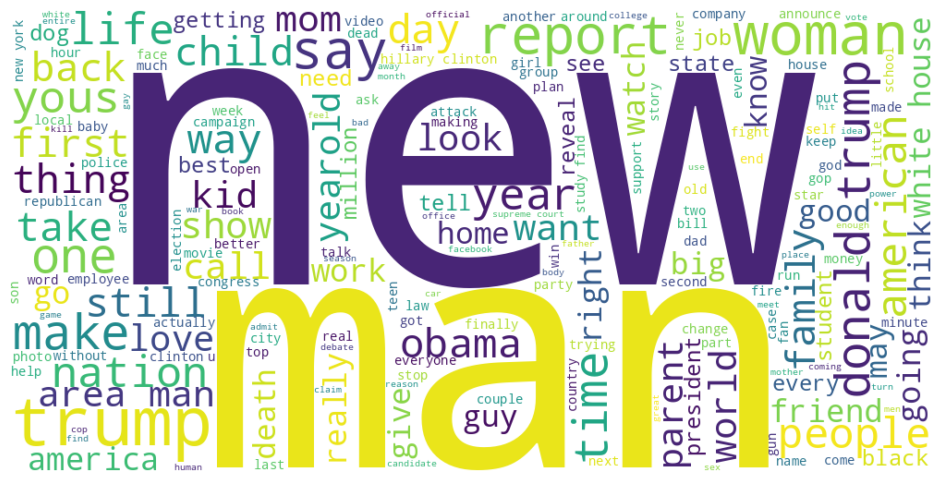

In [14]:
#visualize the cleaned data
#wordcloud to see frequent words
text = " ".join(df['cleaned_headline'])

wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=200, colormap='viridis').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

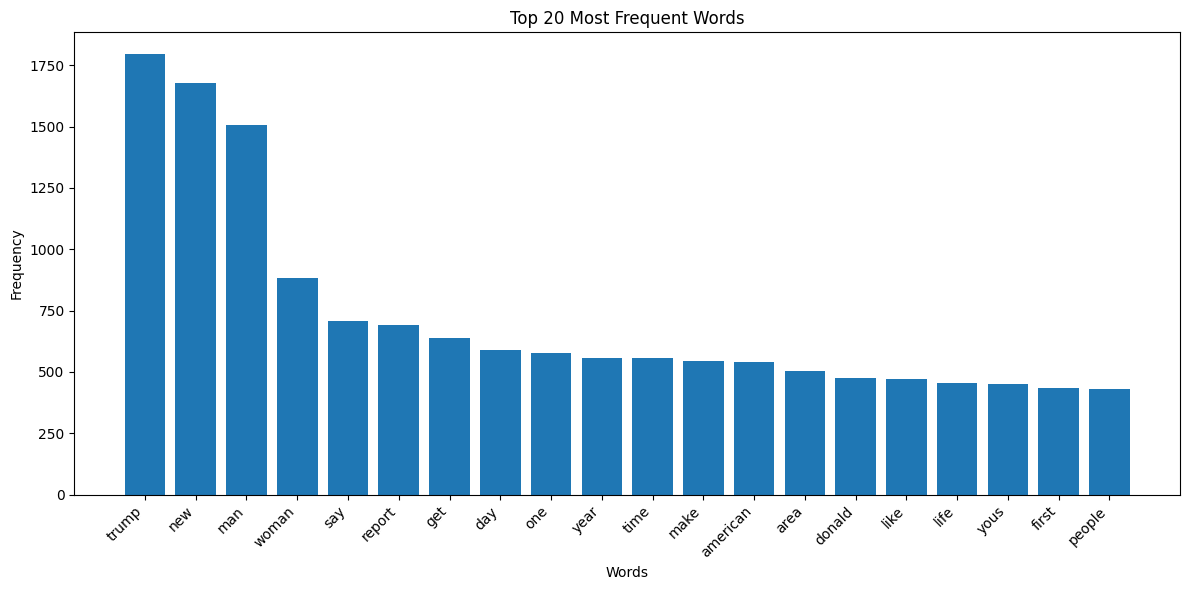

In [15]:
# Most frequent words visualization
words = ' '.join(df['cleaned_headline']).split()
word_counts = Counter(words)
top_20_words = dict(word_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Tokenization and Padding: Convert the cleaned text data into sequences and ensure uniform se-
quence lengths by applying padding:


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['is_sarcastic'])
# stratify ensures both sarcasm classes are balanced

# Text Preprocessing, Tokenization, and Sequence Padding for Training data
print("Tokenizing and padding training data...")
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_headline'])   # Cleaned headline column

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_headline'])

# Calculate 95th percentile max_len
max_len = int(np.percentile([len(seq) for seq in train_sequences], 95))  # 95th percentile

print(f"Max sequence length: {max_len}")

# Pad training data
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
y_train = train_df['is_sarcastic'].values

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Text Preprocessing, Tokenization, and Sequence Padding for Testing data
print("Tokenizing and padding test data...")
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_headline'])

# Pad test data
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
y_test = test_df['is_sarcastic'].values

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

Tokenizing and padding training data...
Vocabulary size: 22523
Max sequence length: 11
Shape of X_train: (22895, 11)
Shape of y_train: (22895,)
Tokenizing and padding test data...
Shape of X_test: (5724, 11)
Shape of y_test: (5724,)


In [17]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved successfully.")


Tokenizer saved successfully.


In [18]:
from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Import class_weight
from sklearn.utils import class_weight

# Calculate class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 0.9582504970178927, 1: 1.0455531453362257}


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

# ModelCheckpoint Callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the Improved RNN model
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),  # Embedding layer
    SimpleRNN(32, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)),  # Regularized RNN
    BatchNormalization(),
    Dropout(0.5),  # Dropout after RNN
    Dense(16, activation='relu'),  # Smaller Dense Layer
    BatchNormalization(),
    Dropout(0.5),  # Dropout after Dense
    Dense(1, activation='sigmoid')  # Output Layer
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0003)

model_rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Build model manually
model_rnn.build(input_shape=(None, max_len))

# Display the model summary
model_rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11, 64)         │     1,441,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445,313 (5.51 MB)

 Trainable params: 1,445,217 (5.51 MB)

 Non-trainable params: 96 (384.00 B)

In [22]:
# Train the model
print("Training model...")
history = model_rnn.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Training model...
Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5211 - loss: 1.3771
Epoch 1: val_accuracy improved from -inf to 0.66652, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5212 - loss: 1.3769 - val_accuracy: 0.6665 - val_loss: 0.9731
Epoch 2/20
560/573 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6835 - loss: 0.9464
Epoch 2: val_accuracy improved from 0.66652 to 0.71806, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6842 - loss: 0.9450 - val_accuracy: 0.7181 - val_loss: 0.8201
Epoch 3/20
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8177 - loss: 0.6716
Epoch 3: val_accuracy improved from 0.71806 to 0.78489, saving model to best_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8178 - loss: 0.6714 - val_accuracy: 0.7849 - val_loss: 0.6582
Epoch 4/20
564/573 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8992 - loss: 0.4639
Epoch 4: val_accuracy did not improve from 0.78489
573/573 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8991 - loss: 0.4637 - val_accuracy: 0.7508 - val_loss: 0.6870
Epoch 5/20
558/573 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9302 - loss: 0.3325
Epoch 5: val_accuracy did not improve from 0.78489
573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9301 - loss: 0.3323 - val_accuracy: 0.7390 - val_loss: 0.7480


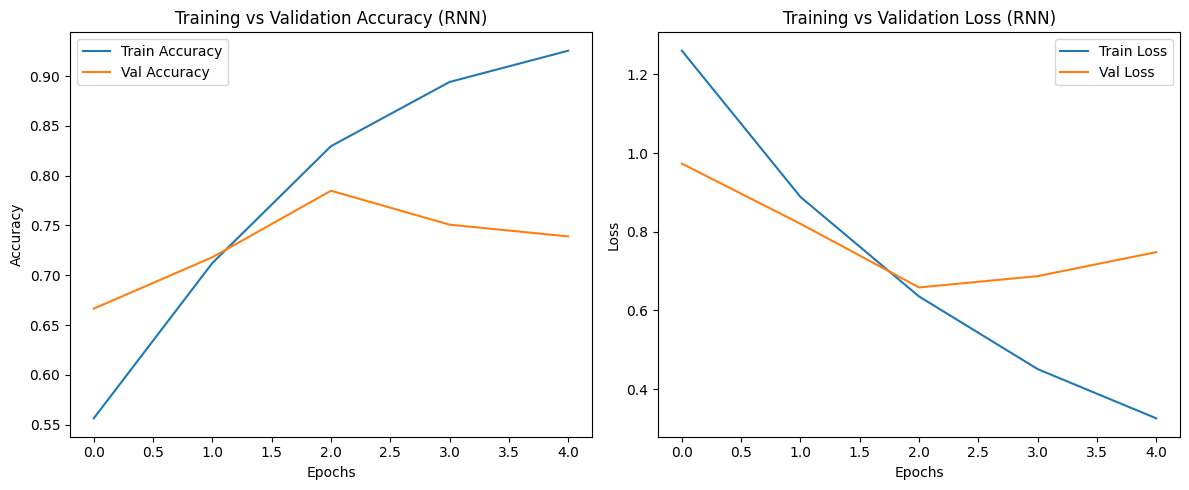

In [23]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Training vs Validation Accuracy (RNN)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss plot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Val Loss')
axs[1].set_title('Training vs Validation Loss (RNN)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


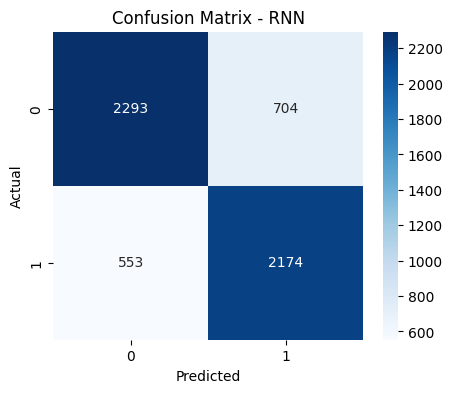

Classification Report - RNN:
              precision    recall  f1-score   support

           0       0.81      0.77      0.78      2997
           1       0.76      0.80      0.78      2727

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict RNN model
y_pred_rnn_probs = model_rnn.predict(X_test)
y_pred_rnn = (y_pred_rnn_probs > 0.5).astype(int)

# Confusion Matrix for RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report for RNN
print("Classification Report - RNN:")
print(classification_report(y_test, y_pred_rnn))


LSTM

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Evaluate the model on test data
print("Evaluating model on test data...")
from sklearn.metrics import classification_report
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Define the LSTM model
model_lstm = Sequential()

# Add Embedding layer
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

# Add LSTM layer with L2 regularization and smaller size
model_lstm.add(LSTM(units=64, kernel_regularizer=l2(0.002), return_sequences=False)),
model_lstm.add(BatchNormalization())

# Optional Dropout to prevent overfitting
model_lstm.add(Dropout(0.4))

# Dense layer
model_lstm.add(Dense(32, activation='relu'))

#batchnormalization
model_lstm.add(BatchNormalization())

# Another Dropout
model_lstm.add(Dropout(0.3))

# Output layer
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.00015)
model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Build (optional to avoid unbuilt warning)
model_lstm.build(input_shape=(None, max_len))

# Show model summary
model_lstm.summary()

Evaluating model on test data...
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7817 - loss: 0.6692
Test Loss: 0.6644
Test Accuracy: 0.7804


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 128)        │     2,882,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,934,849 (11.20 MB)

 Trainable params: 2,934,657 (11.19 MB)

 Non-trainable params: 192 (768.00 B)

Train the model


In [26]:
from keras.callbacks import EarlyStopping

# Set up EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience= 2, restore_best_weights=True)
# Model Checkpoint
model_checkpoint = ModelCheckpoint('lstm_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history_lstm = model_lstm.fit(
    X_train_final,
    y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/20
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5528 - loss: 1.0509

573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5529 - loss: 1.0505 - val_accuracy: 0.7375 - val_loss: 0.7046
Epoch 2/20
570/573 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7696 - loss: 0.5986

573/573 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7697 - loss: 0.5983 - val_accuracy: 0.7783 - val_loss: 0.5783
Epoch 3/20
567/573 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8880 - loss: 0.3661

573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8880 - loss: 0.3660 - val_accuracy: 0.7790 - val_loss: 0.5834
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9312 - loss: 0.2668 - val_accuracy: 0.7670 - val_loss: 0.6800


In [27]:
# Evaluate the model on test data
print("Evaluating LSTM model on test data...")

loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_lstm:.4f}")
print(f"Test Accuracy: {accuracy_lstm:.4f}")


Evaluating LSTM model on test data...
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7825 - loss: 0.5708
Test Loss: 0.5603
Test Accuracy: 0.7881


Visualize training result

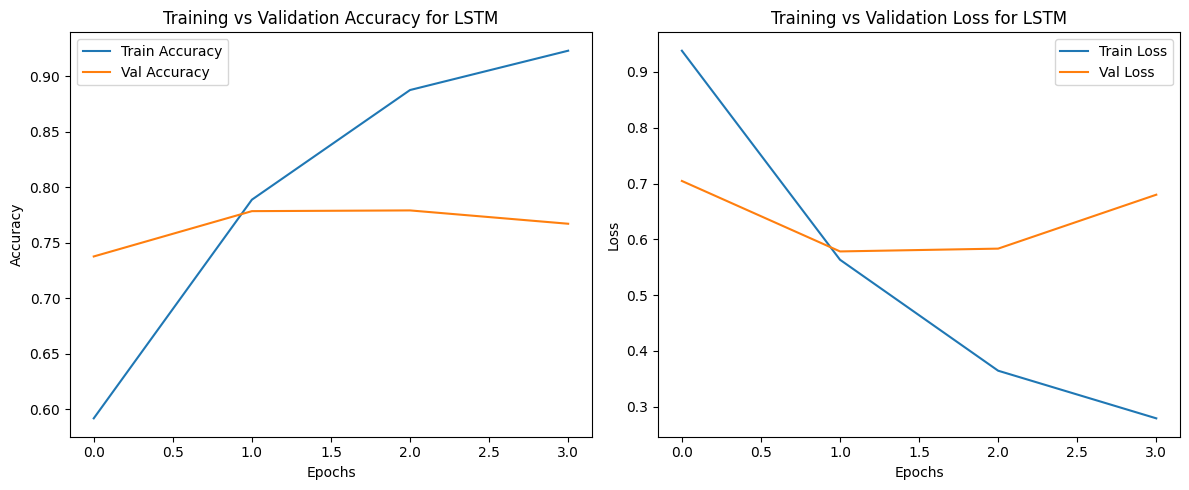

In [28]:
import matplotlib.pyplot as plt

# Create subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training vs. Validation Accuracy
axs[0].plot(history_lstm.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Training vs Validation Accuracy for LSTM')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Training vs. Validation Loss
axs[1].plot(history_lstm.history['loss'], label='Train Loss')
axs[1].plot(history_lstm.history['val_loss'], label='Val Loss')
axs[1].set_title('Training vs Validation Loss for LSTM')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust spacing and show
plt.tight_layout()
plt.show()


Evaluate the model
Evaluate the model on the validation data.

Generate the confusion matrix and classification report for detailed performance evaluation.

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


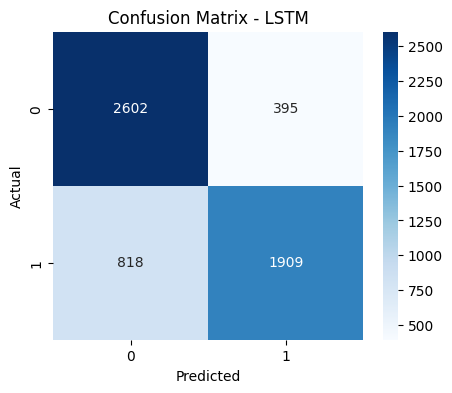

Classification Report - LSTM:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      2997
           1       0.83      0.70      0.76      2727

    accuracy                           0.79      5724
   macro avg       0.79      0.78      0.78      5724
weighted avg       0.79      0.79      0.79      5724



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_pred_lstm_probs = model_lstm.predict(X_test)
y_pred_lstm = (y_pred_lstm_probs > 0.5).astype(int)

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report - LSTM:")
print(classification_report(y_test, y_pred_lstm))


Plotting Accuracy & Loss for RNN and LSTM

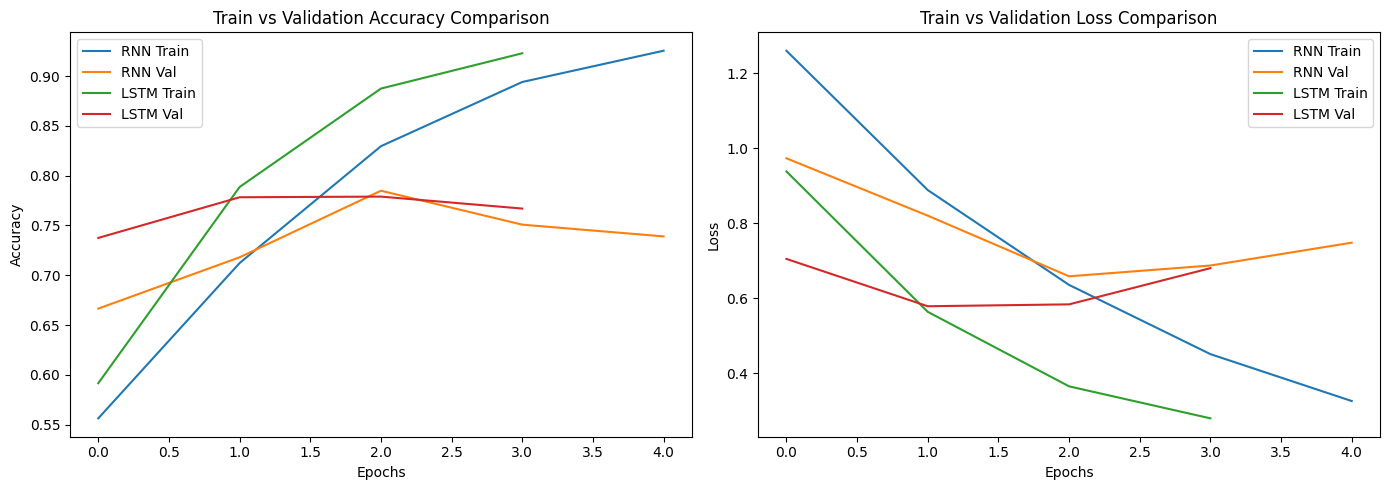

In [30]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Comparison
axs[0].plot(history.history['accuracy'], label='RNN Train')
axs[0].plot(history.history['val_accuracy'], label='RNN Val')
axs[0].plot(history_lstm.history['accuracy'], label='LSTM Train')
axs[0].plot(history_lstm.history['val_accuracy'], label='LSTM Val')
axs[0].set_title('Train vs Validation Accuracy Comparison')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss Comparison
axs[1].plot(history.history['loss'], label='RNN Train')
axs[1].plot(history.history['val_loss'], label='RNN Val')
axs[1].plot(history_lstm.history['loss'], label='LSTM Train')
axs[1].plot(history_lstm.history['val_loss'], label='LSTM Val')
axs[1].set_title('Train vs Validation Loss Comparison')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


Evaluate Accuracy, Confusion Matrix, Classification Report

In [31]:
# RNN
print("RNN Evaluation:")
loss_rnn, acc_rnn = model_rnn.evaluate(X_test, y_test)
print(f"Accuracy: {acc_rnn:.4f}")
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred_rnn))
print(classification_report(y_test, y_pred_rnn))

# LSTM
print("\nLSTM Evaluation:")
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f"Accuracy: {acc_lstm:.4f}")
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


RNN Evaluation:
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7817 - loss: 0.6692
Accuracy: 0.7804
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2293  704]
 [ 553 2174]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.78      2997
           1       0.76      0.80      0.78      2727

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724


LSTM Evaluation:
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7825 - loss: 0.5708
Accuracy: 0.7881
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2602  395]
 [ 818 1909]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      2997
           1       0.83      0.70      0.76      2727

    accuracy                           0.79      5724
   macro avg       0.79      0.78      0.78      5724
weighted avg       0.79      0.79      0.79    

In [32]:
print("Model Comparison Summary:")
print(f"RNN Accuracy:  {acc_rnn}")
print(f"LSTM Accuracy: {acc_lstm}")


Model Comparison Summary:
RNN Accuracy:  0.7803983092308044
LSTM Accuracy: 0.7880852818489075


LSTM with pretrained Word2Vec embeddings.

In [1]:
!pip install gensim
!pip install --upgrade jax==0.4.13 jaxlib==0.4.13

In [2]:
import gensim.downloader as api
word2vec = api.load("glove-wiki-gigaword-300")
print("Pretrained GloVe 300D Model Loaded!")

[==================================================] 100.0% 376.1/376.1MB downloaded
Pretrained GloVe 300D Model Loaded!


In [33]:
import numpy as np

embedding_dim = 300  # Because GloVe is 300-dimensional
vocab_size = len(tokenizer.word_index) + 1

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Build word -> vector mapping
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    else:
        # If word not in pretrained vectors, leave embedding_vector as zeros
        pass


In [34]:
# Build the LSTM model
from tensorflow.keras.regularizers import l2
model_lstm_w2v = Sequential()
model_lstm_w2v.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True
))

model_lstm_w2v.add(LSTM(64, kernel_regularizer=l2(0.001)))
model_lstm_w2v.add(Dropout(0.5))
model_lstm_w2v.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_lstm_w2v.add(Dropout(0.3))
model_lstm_w2v.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model_lstm_w2v.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Build model manually
model_lstm_w2v.build(input_shape=(None, max_len))

# Show model summary
model_lstm_w2v.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 11, 300)        │     6,756,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,854,565 (26.15 MB)

 Trainable params: 6,854,565 (26.15 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm_w2v = model_lstm_w2v.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5695 - loss: 0.9629 - val_accuracy: 0.7032 - val_loss: 0.7490
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7456 - loss: 0.6918 - val_accuracy: 0.7630 - val_loss: 0.6225
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8148 - loss: 0.5506 - val_accuracy: 0.7827 - val_loss: 0.5685
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8592 - loss: 0.4581 - val_accuracy: 0.7956 - val_loss: 0.5475
Epoch 5/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8874 - loss: 0.3904 - val_accuracy: 0.7997 - val_loss: 0.5489
Epoch 6/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9158 - loss: 0.3238 - val_accuracy: 0.8037 - val_loss: 0.5599
Epoch 7/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9404 - loss: 0.2669 - val_accuracy: 0.7971 - val_loss: 0.6207


In [37]:
loss, accuracy = model_lstm_w2v.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8105 - loss: 0.5342
Test Accuracy: 0.8082


In [38]:
model_lstm.save("lstm_model.h5")
model_lstm_w2v.save("lstm_word2vec_model.h5")


In [39]:
from tensorflow.keras.models import load_model
model_loaded = load_model("lstm_word2vec_model.h5")

Each module most include:
• Embedding Layer:
– For model1 and 2 use Embedding layer:
∗ rnn model.add(Embedding(input dim= , output dim= , input length= ))
– For model 3 Use Word2Vec pretrained embeddings {A sample implementation is provided at the
Appendix Section of this document.}
• Recurrent Layer: SimpleRNN for model 1 and LSTM for models 2 and 3.
• Dense Output Layer:

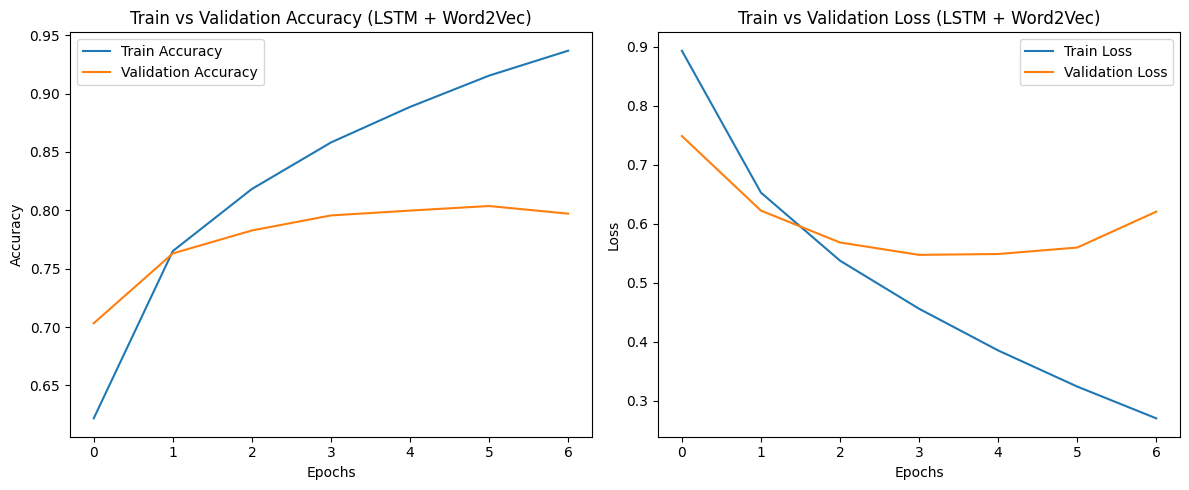

In [40]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training vs Validation Accuracy
axs[0].plot(history_lstm_w2v.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_lstm_w2v.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Train vs Validation Accuracy (LSTM + Word2Vec)')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot Training vs Validation Loss
axs[1].plot(history_lstm_w2v.history['loss'], label='Train Loss')
axs[1].plot(history_lstm_w2v.history['val_loss'], label='Validation Loss')
axs[1].set_title('Train vs Validation Loss (LSTM + Word2Vec)')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


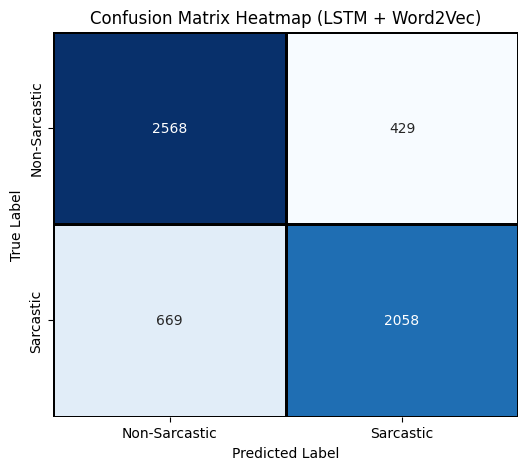

Classification Report - LSTM + Word2Vec
               precision    recall  f1-score   support

Non-Sarcastic       0.79      0.86      0.82      2997
    Sarcastic       0.83      0.75      0.79      2727

     accuracy                           0.81      5724
    macro avg       0.81      0.81      0.81      5724
 weighted avg       0.81      0.81      0.81      5724



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict on X_test
y_pred_probs = model_lstm_w2v.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot heatmap with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Sarcastic', 'Sarcastic'],
            yticklabels=['Non-Sarcastic', 'Sarcastic'],
            linewidths=1, linecolor='black')

plt.title('Confusion Matrix Heatmap (LSTM + Word2Vec)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 4: Print classification report
print("Classification Report - LSTM + Word2Vec")
print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))


In [42]:
# Evaluate LSTM + Word2Vec model
loss_lstm_w2v, acc_lstm_w2v = model_lstm_w2v.evaluate(X_test, y_test)
print(f"Test Loss: {loss_lstm_w2v:.4f}")
print(f"Test Accuracy: {acc_lstm_w2v:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8105 - loss: 0.5342
Test Loss: 0.5368
Test Accuracy: 0.8082


In [43]:
print("Model Comparison Summary:")
print(f"RNN Accuracy:              {acc_rnn:.4f}")
print(f"LSTM Accuracy:             {acc_lstm:.4f}")
print(f"LSTM + Word2Vec Accuracy:  {acc_lstm_w2v:.4f}")

Model Comparison Summary:
RNN Accuracy:              0.7804
LSTM Accuracy:             0.7881
LSTM + Word2Vec Accuracy:  0.8082


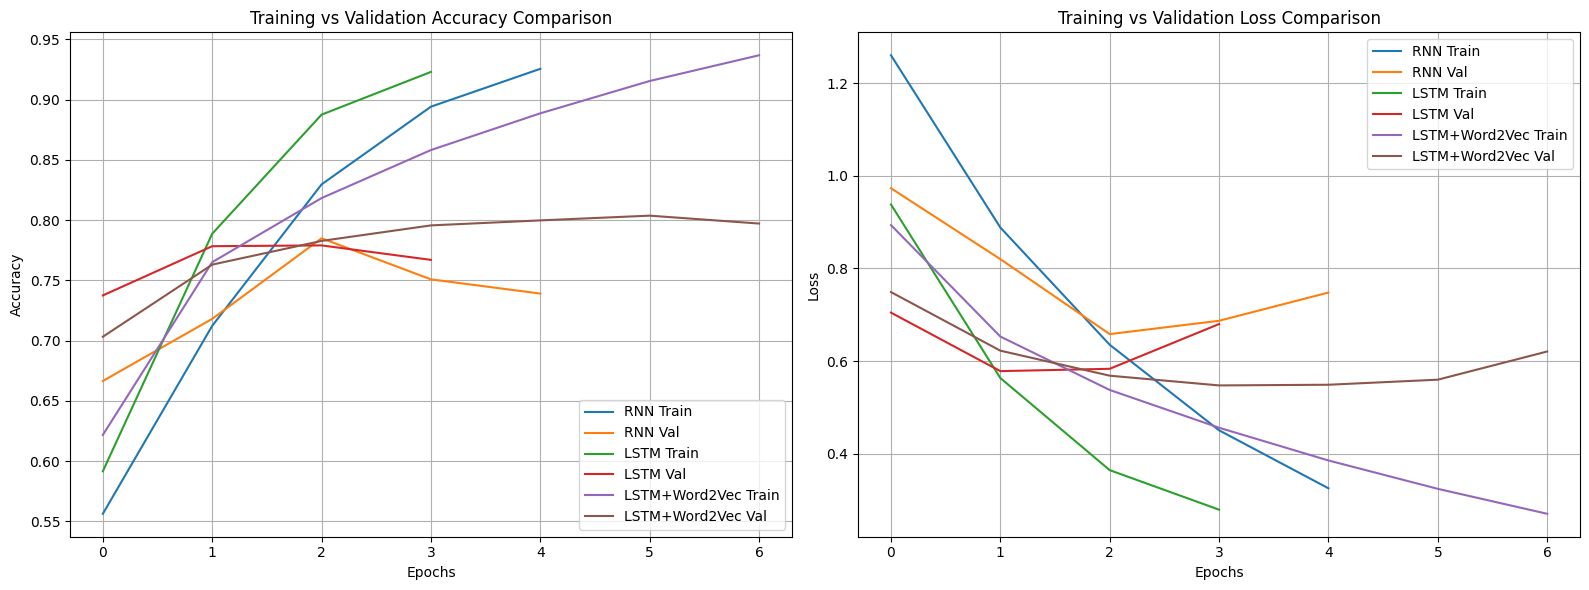

In [44]:
import matplotlib.pyplot as plt

# Create 2 subplots (Accuracy and Loss)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- ACCURACY COMPARISON ---
axs[0].plot(history.history['accuracy'], label='RNN Train')
axs[0].plot(history.history['val_accuracy'], label='RNN Val')
axs[0].plot(history_lstm.history['accuracy'], label='LSTM Train')
axs[0].plot(history_lstm.history['val_accuracy'], label='LSTM Val')
axs[0].plot(history_lstm_w2v.history['accuracy'], label='LSTM+Word2Vec Train')
axs[0].plot(history_lstm_w2v.history['val_accuracy'], label='LSTM+Word2Vec Val')

axs[0].set_title('Training vs Validation Accuracy Comparison')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# --- LOSS COMPARISON ---
axs[1].plot(history.history['loss'], label='RNN Train')
axs[1].plot(history.history['val_loss'], label='RNN Val')
axs[1].plot(history_lstm.history['loss'], label='LSTM Train')
axs[1].plot(history_lstm.history['val_loss'], label='LSTM Val')
axs[1].plot(history_lstm_w2v.history['loss'], label='LSTM+Word2Vec Train')
axs[1].plot(history_lstm_w2v.history['val_loss'], label='LSTM+Word2Vec Val')

axs[1].set_title('Training vs Validation Loss Comparison')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Adjust layout nicely
plt.tight_layout()
plt.show()


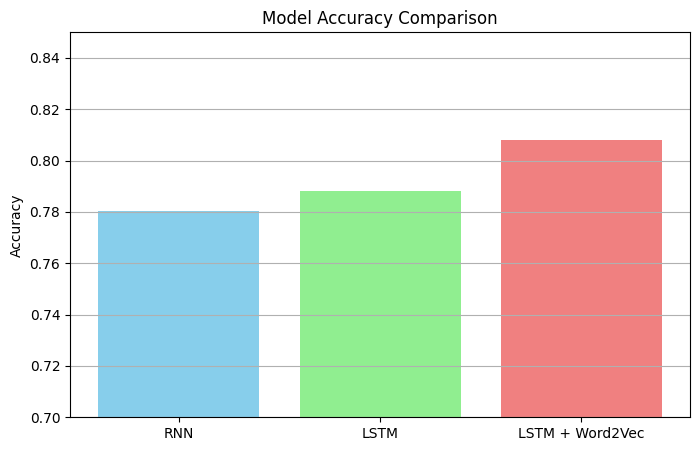

In [45]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['RNN', 'LSTM', 'LSTM + Word2Vec']
accuracies = [acc_rnn, acc_lstm, acc_lstm_w2v]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.85)
plt.grid(axis='y')
plt.show()


3.4 GUI


In [46]:
!pip install Gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00


In [48]:
# ==== 1. All necessary imports ====
import gradio as gr
import re
import contractions
import nltk
import pickle
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==== 2. Download NLTK resources ====
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ==== 3. Load saved model and tokenizer ====
model_lstm_w2v = load_model('lstm_word2vec_model.h5')  # Ensure this file exists in the working directory

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_len = 50

# ==== 4. Initialize stopwords and lemmatizer ====
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ==== 5. Text preprocessing function ====
def preprocess_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text

# ==== 6. Prediction function (fixed logic) ====
def predict_sarcasm(text):
    try:
        cleaned_text = preprocess_text(text)
        sequence = tokenizer.texts_to_sequences([cleaned_text])
        padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
        prediction = model_lstm_w2v.predict(padded)[0][0]

        # FIXED: Flip prediction logic
        if prediction >= 0.5:
            return f"Not Sarcastic 🙂 (Confidence: {prediction:.2f})"
        else:
            return f"Sarcastic 😀 (Confidence: {1 - prediction:.2f})"

    except Exception as e:
        return f"Error: {str(e)}"

# ==== 7. Create Gradio Interface ====
interface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=2, placeholder="Enter a news headline here..."),
    outputs=gr.Textbox(),
    title="Sarcasm Detection (LSTM + Word2Vec)",
    description="Enter a news headline. This model will predict whether it is sarcastic or not.",
    examples=[
        ["Oh great, another Monday! Just what I needed."],
        ["Scientists discover water on Mars."],
        ["Wow, traffic jam at 7 a.m.? Never saw that coming."],
        ["Local man wins lottery, plans to buy a new house."]
    ],
    theme="default"
)

# ==== 8. Launch the Interface ====
interface.launch(share=True, debug=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://09e783014273228593.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://09e783014273228593.gradio.live
